## Integrantes: Ruiz Jose - Parraga María José - Borja Leonardo


### Importar librerias


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Descripción del dataset (DATOS)

#### VARIABLES DE ENTRADA

**age:** edad del beneficiario principal

**sex:** contratista de seguros género, femenino, masculino

**bmi:** Índice de masa corporal, que proporciona una comprensión del cuerpo, pesos que son relativamente altos o bajos en relación con la altura, 

**objetive:** índice objetivo de peso corporal (kg / m ^ 2) utilizando la relación entre altura y peso, idealmente 18,5 a 24,9

**children:** Número de niños cubiertos por el seguro de salud / Número de dependientes

**smoker:** fumar

**region:** el área residencial del beneficiario en los EE. UU., noreste, sureste, suroeste, noroeste.

**charges:** costos médicos individuales facturados por el seguro de salud

#### CARGAR DATOS DEL DATASET Y RENOMBRAMIENTO DE LAS VARIABLES

In [5]:
#datos cargados = archivo tipo pandas
datos = pd.read_csv('insurance.csv',  sep = "," )  

# Cambiar el nombre de las columnas para mostrar más 
datos.columns=[ "edad","sexo" ,"masa corporal" ,"niños", 
                 "fumadores","region", "cargos"]


### ANÁLISIS EXPLOTARIO

In [6]:
#mostrar los 10 primeros registros
datos.head(10)

,edad,sexo,masa corporal,niños,fumadores,region,cargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


#### Tipo de cada columna


In [18]:
#Mostrar los tipos de datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   edad           1338 non-null   int64  
 1   sexo           1338 non-null   object 
 2   masa corporal  1338 non-null   float64
 3   niños          1338 non-null   int64  
 4   fumadores      1338 non-null   object 
 5   region         1338 non-null   object 
 6   cargos         1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Division del dataset y verificación de datos nulos

In [19]:
datos.shape

(1338, 7)

In [20]:
# Número de datos ausentes por variable
datos.isna().sum().sort_values()

edad             0
sexo             0
masa corporal    0
niños            0
fumadores        0
region           0
cargos           0
dtype: int64

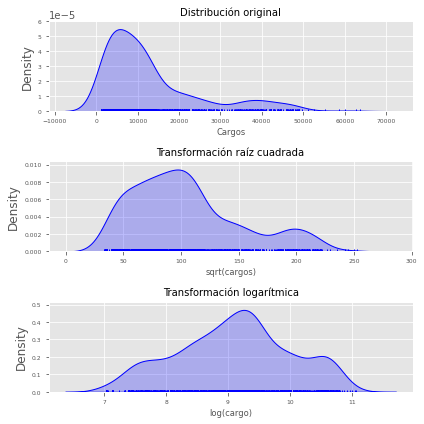

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.distplot(
    datos.cargos,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Cargos', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(datos.cargos),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(cargos)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(datos.cargos),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(cargo)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

# VARIABLES NUMERICAS

In [13]:
# Variables numéricas
# ==============================================================================
datos.select_dtypes(include=['float64', 'int']).describe()

,edad,masa corporal,niños,cargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


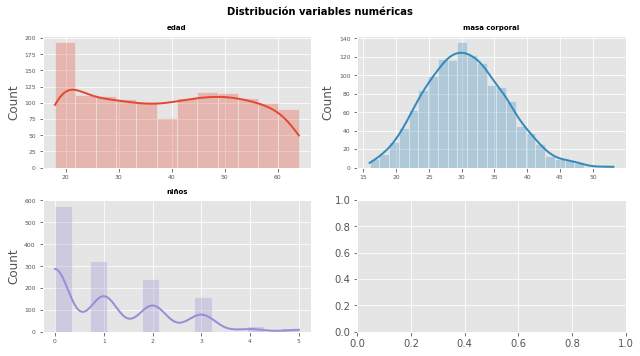

In [17]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('cargos')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable niños, aunque es de tipo numérico, apenas toma unos pocos valores y la gran mayoría de 
observaciones pertenecen a solo dos de ellos. 
En casos como este, suele ser conveniente tratar la variable como cualitativa.

In [19]:
# Valores observados de chimenea
# ==============================================================================
datos.niños.value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: niños, dtype: int64

In [20]:
# Se convierte la variable chimenea tipo string
# ==============================================================================
datos.niños = datos.niños.astype("str")

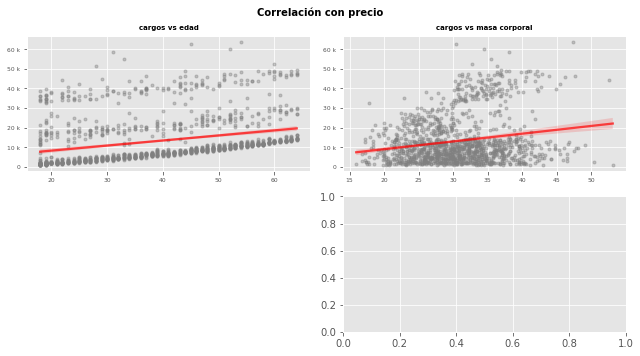

In [28]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('cargos')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = datos[colum],
        y           = datos['cargos'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"cargos vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [2]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con precio', fontsize = 10, fontweight = "bold");

# Correlación variables numéricas

In [29]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
2,edad,cargos,0.299008,0.299008
6,cargos,edad,0.299008,0.299008
5,masa corporal,cargos,0.198341,0.198341
7,cargos,masa corporal,0.198341,0.198341
1,edad,masa corporal,0.109272,0.109272
3,masa corporal,edad,0.109272,0.109272


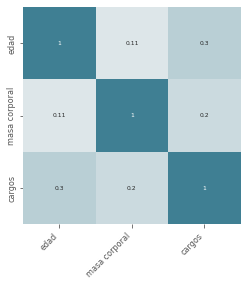

In [30]:
# matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

# Variables Cualitativas

In [31]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

,sexo,niños,fumadores,region
count,1338,1338,1338,1338
unique,2,6,2,4
top,male,0,no,southeast
freq,676,574,1064,364


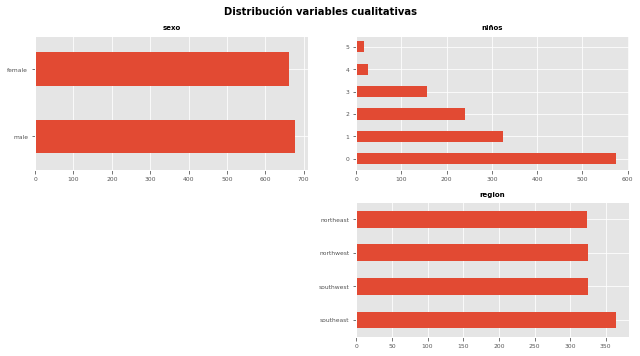

In [43]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [2]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

In [44]:
datos.niños.value_counts().sort_index()

0    574
1    324
2    240
3    157
4     25
5     18
Name: niños, dtype: int64

In [ ]:
# EL SIGUIENTE PASO CREO QUE NO SE HACE PORQUE QUITA A LAS VARIABLES QUE TENGAN POCOS VALORES
#PERO CON TODO DEJO EL CÓDIGO
#dic_replace = {'2': "2_mas",
 #              '3': "2_mas",
  #             '4': "2_mas"}

#datos['cargos'] = datos['cargos'] \
 #                    .map(dic_replace) \
  #                   .fillna(datos['cargos'])

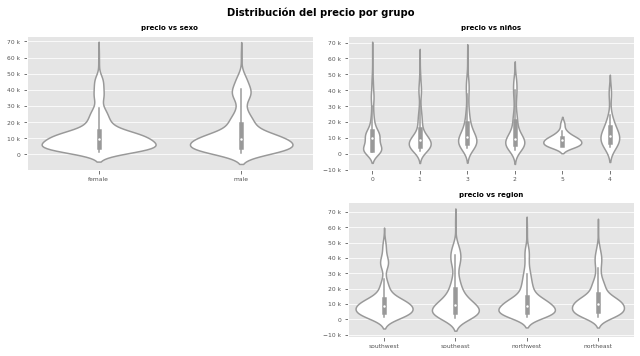

In [48]:
# Gráfico relación entre el cargo y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.violinplot(
        x     = colum,
        y     = 'cargos',
        data  = datos,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"precio vs {colum}", fontsize = 7, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [2]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución del precio por grupo', fontsize = 10, fontweight = "bold");

# División train y test

In [49]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('cargos', axis = 'columns'),
                                        datos['cargos'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [50]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count     1070.000000
mean     13302.284296
std      12137.030178
min       1131.506600
25%       4806.138175
50%       9369.615750
75%      16454.504562
max      63770.428010
Name: cargos, dtype: float64


In [51]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count      268.000000
mean     13143.211917
std      12023.242046
min       1121.873900
25%       4520.472025
50%       9398.583150
75%      17300.427550
max      48824.450000
Name: cargos, dtype: float64
